<a href="https://colab.research.google.com/github/SudeepSarkar/Undergraduate-Computer-Vision/blob/main/CAP_4410_Lecture_27_Kalman_Tracking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

(c) Copyright Sudeep Sarkar, University of South Florida, 2021

# Tracking of image features

You will learn about 

* The problem of motion tracking in different contexts
* Kalman tracking that allows for the use of a prior motion model to constrain the tracks and estimation of state parameters that are not directly observable, such as velocity, acceleration, etc.
* Examples of tracking in video of points and objects.


Relevant chapters in the textbook

* 7.1.5 Feature tracking
* 9.4.4 Video object tracking

# Useful prior code


## Mount Google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Standard Imports

In [5]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import scipy.ndimage as scimage
import torch.nn as nn
from skimage import io
from skimage.feature import peak_local_max

!pip install opencv-contrib-python==4.4.0.44
import cv2
print (cv2 .__version__)

!pip install xmltodict
import xmltodict
from scipy.spatial.transform import Rotation 

np.set_printoptions(precision=2)

4.4.0


## Code to display error ellipses

In [ ]:
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
# This function was taken/adapted from https://matplotlib.org/devdocs/gallery/statistics/confidence_ellipse.html
def confidence_ellipse(cov, mu, ax, n_std=1.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse 
    Parameters
    ----------
    cov : 2 by 2 covariance matrix
        Input data.
    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.
    **kwargs
        Forwarded to `~matplotlib.patches.Ellipse`
    Returns
    -------
    Ellipse
    """
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0), width=ell_radius_x * 2, height=ell_radius_y * 2,
                      facecolor=facecolor, **kwargs)
    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = mu[0]
    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = mu[1]
    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)
    ellipse.set_transform(transf + ax.transData)
    return ellipse

# Motion tracking in video

* Given a starting location on a moving object (car, person, cells, animals, etc.), the **task of tracking** is to locate the same point in the subsequent frames, possibily along with estimates of velocity, acceleration, etc in 2D and 3D. 

* See The Multiple Object Tracking Benchmark for examples: https://motchallenge.net/

* CellTracker: program for automated cell tracking on biological images:  http://www.celltracker.website/index.html

* http://celltrackingchallenge.net/2d-datasets/

* Small animal tracking: https://animapp.readthedocs.io/en/latest/index.html

* We can track (i) **salient points**, such as corners, or (ii) bounding boxed entities in frames, or (iii) 3D object shapes.

* In this lecture, we will consider regular cameras looking at people. The application context is self-driving cars. We need to track and predict the motion of people to avoid collisions. 

* We will consider fixed cameras. This imaging setup is the simplest imaging model we can consider for this problem. However, whatever we develop here can be generalized and formulated for other complex cases such as moving cameras with moving objects. 



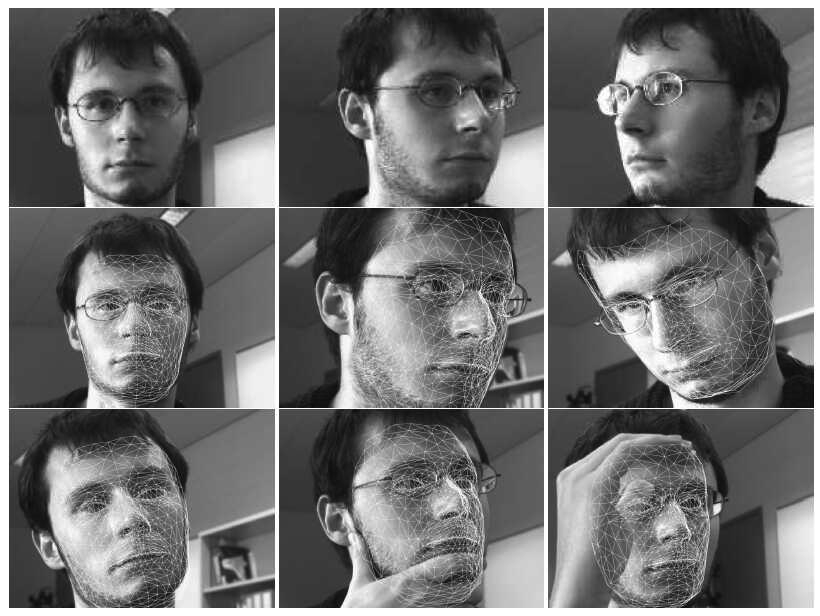

# Architecture of motion tracking
 * Taken from: Smeulders, A. W. M., Chu, D. M., Cucchiara, R., Calderara, S., Dehghan, A, and Shah, M. (2014). [Visual tracking: An experimental survey.](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=6671560) IEEE Transactions on Pattern Analysis and Machine Intelligence, 36(7):1442–1468.

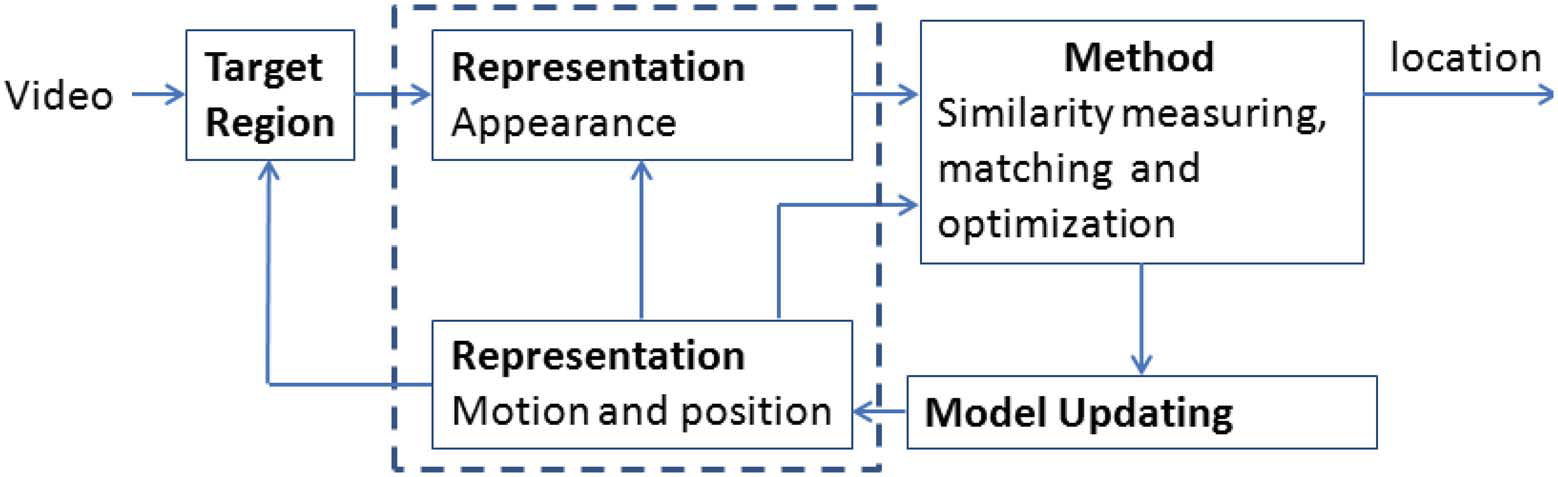

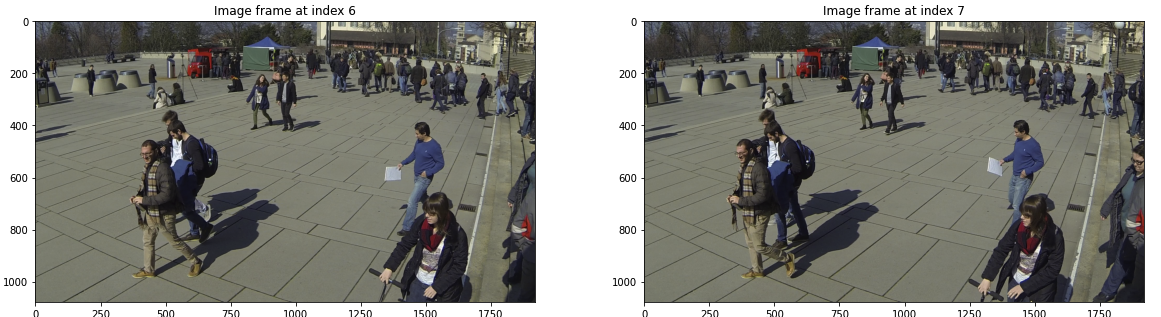

# [Kalman](https://en.wikipedia.org/wiki/Rudolf_E._K%C3%A1lm%C3%A1n) tracking: The problem setup

* We will differentiate between the state, ${\bf s_t}$, of the moving object and the measurements we make about the movement, ${\bf m_t}$. 

* The moving objects' **states** are the location of the objects' points with their velocity and acceleration. 

* We might not have measurements for all the state quantities. For instance, we can use the locations of features in the image to estimate the *underlying* points on the object; this is our measurement. However, for velocity or acceleration, we do not have any direct measurements. 
    * The Kalman filtering process, which we will employ, will estimate the full state vector from the state's partial measurement.

* We model all this in three steps. The figure below diagrams the different aspects.  
    * First, we will specify the **underlying state** of the points. Note the state of the points are not directly observed.
    * Second, we will model the **measurement process**. We do not have direct access to the state. We can only measure some aspects of it. 
    * Third, we will specify the model governing the underlying movement - **state change model**.

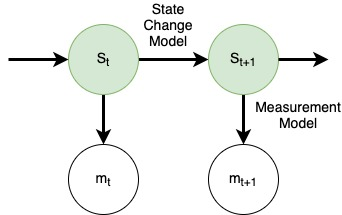

# 1. State specification

* Let $\mathbf{s}_t$ denote the state of the moving objects at time $t$. Possible choices of the state vector are: just location, 
$\begin{bmatrix}
        x \\ y 
\end{bmatrix}$
or location and velocity
$\begin{bmatrix}
        x \\ y \\ v_x \\ v_y
\end{bmatrix}$
or location, velocity, and bounding box size
$\begin{bmatrix}
        x \\ y \\ w \\ h \\ v_x \\ v_y
\end{bmatrix}$
or location, velocity, acceleration, and bounding box size
$\begin{bmatrix}
        x \\ y \\ w \\ h \\ v_x \\ v_y \\ a_x \\ a_y
\end{bmatrix}$

* This state is a random variable as we do not know the exact value. We assume it is a Gaussian random variable, with a mean value, $\hat{\mathbf{s}}_t$, and a covariance $\mathbf{P}_t$ capturing the uncertainty about the state.




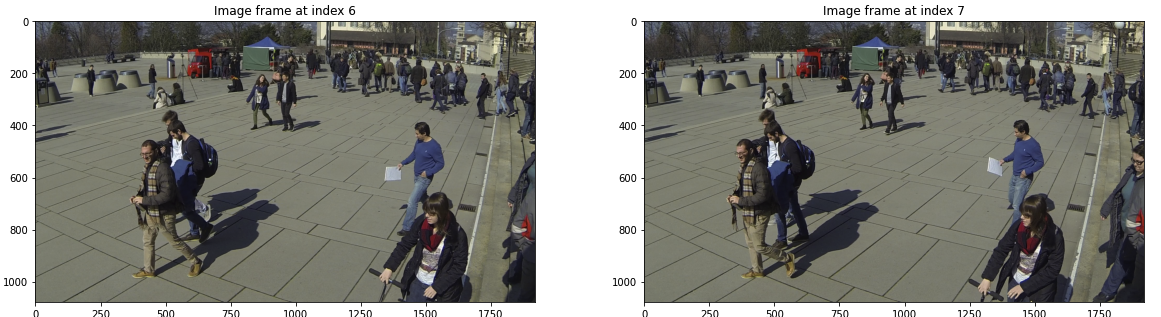

# 2. Measurement Model

* We can **measure** the point locations using any point detector, e.g. SIFT detector. However, we do not have measurements for velocity or acceleration.

* The **measurement process** consists of running a point detector, such as SIFT, in the next frame and picking a response in the next frame that is the best match. 

* This measurement is inherently noisy and uncertain. Some points, such as corners, can be located more precisely than others on a boundary edge. We will capture this uncertainty in the measurement model.
    * For SIFT detector, we can use the scale at which the keypoint was detected as the estimate of the uncertainty in the location of the point.
    * In the OpenCV implementation, we can use the "size" field of the keypoints in the OpenCV, which estimates the diameter of the meaningful keypoint neighborhood.

* A measurement model relates the measurement with the underlying model states. In general, the **dimension of the measurement vector would be lower than the state vector**.  
    * For instance, we can measure the location directly, but not the velocity or acceleration, so the measurement vector, in that case, will consist of just the location values. 

* Let the measurement vector be denoted by  $\mathbf{m}_t$ and the relationship with the state vector $\mathbf{s}_t$ be related by

\begin{equation}
        \mathbf{m}_t = \mathbf{H} \mathbf{s}_t + \mathbf{w}
\end{equation}

>> where $\mathbf{w}$ is the measurement error, which again will be assumed to be zero mean with some covariance, $\mathbf{R}$, capturing the uncertainty of the measurement. 
    
* One example of a measurement model for the point tracking case is given by:

\begin{equation}
    \begin{bmatrix}
        r \\ c 
    \end{bmatrix}_{t+1} = 
    \begin{bmatrix}
    1 & 0 & 0 & 0 \\
    0 & 1 & 0 & 0
    \end{bmatrix} 
    \begin{bmatrix}
        x \\ y \\ v_x \\ v_y
    \end{bmatrix}_{t} + 
    \begin{bmatrix}
        w_0 \\ w_1 
    \end{bmatrix}
\end{equation}

* The measurement covariance $\mathbf{R}$ is a $2 \times 2$ matrix capturing the two dimensional uncertainty. **Its "shape" can be represented as an ellipse denoting region of equal uncertainty.**
    * Some illustrations of 2D covariances can be seen at https://en.wikipedia.org/wiki/Covariance_matrix

\begin{equation}
\mathbf{R} = 
\begin{bmatrix}
\sigma^2_{r} & \sigma_{rc} \\ 
\sigma_{cr} & \sigma^2_{c}
\end{bmatrix}
\end{equation}


## Code: SIFT point "measurements"

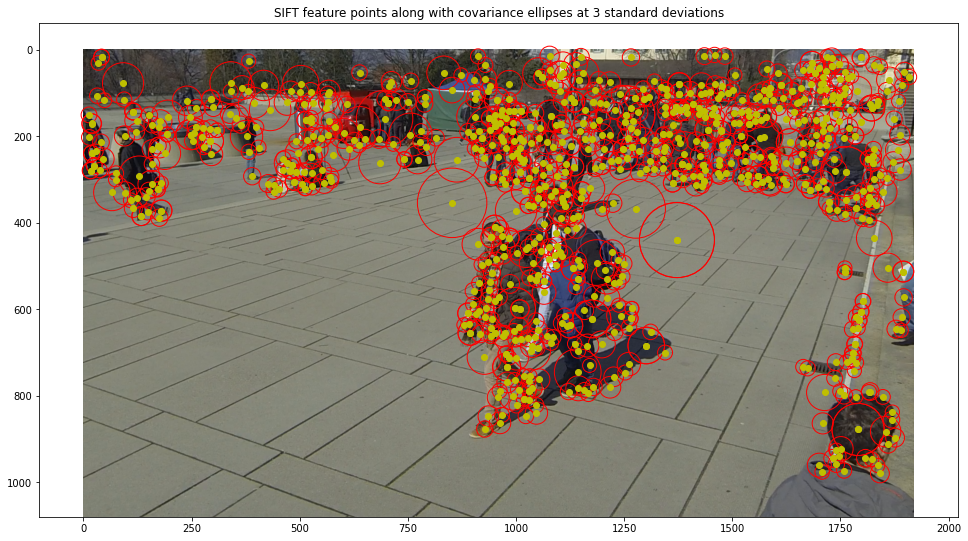

In [ ]:
def detect_SIFT_keypoints (image_1) :
    # input: image_1 ideally of size around 256 by 256
    # runs OpenCV SIFT detector with default parameters
    # returns: SIFT key points and descriptors for image along  
    
    sift = cv2.SIFT_create(nOctaveLayers = 3, contrastThreshold = 0.04, edgeThreshold = 10, sigma = 1.6)

    keypoints_1, descriptors_1 = sift.detectAndCompute(image_1, None)

    X_1 = []
    for i in range(len(keypoints_1)) :
        X_1.append([keypoints_1[i].pt[0], keypoints_1[i].pt[1]])
        
    X_1 = np.array(X_1)

    '''
    # Keypoint class is described in at https://docs.opencv.org/master/d2/d29/classcv_1_1KeyPoint.html
    # We can use the "size" field of the keypoints, which estimates the diameter of the meaningful keypoint neighborhood, 
    # uncertainty in the estimate of the location of the point, i.e. the measurement COVARIANCE, R
    '''

    X_size = []
    for i in range (X_1.shape[0]) :
        b = np.array([[keypoints_1[i].size, 0],[0, keypoints_1[i].size]])
        X_size.append(b)
    X_size = np.array(X_size)

    return(X_1, X_size, keypoints_1)
#-----------------------------------------------------------------------------

from skimage.transform import warp, rescale, resize
from skimage import io
from skimage.util import img_as_ubyte

#----------------read and resize image to suit SIFT detector ------------------------
image_0 = io.imread('/content/drive/MyDrive/Colab Notebooks/data/Wildtrack/C1/00000000.png')

# the openCV SIFT detector works best with images of size around 256 by 256 so we downscale
# to detect and match the features and then scale the location s of the pixels up.
down_scale = 0.25
down_size = (down_scale*image_0.shape[0], down_scale*image_0.shape[1])
image_0_rescaled = resize(image_0, down_size, anti_aliasing=True)
#print ('Image downscaled from:', image_0.shape, ' to:', image_0_rescaled.shape)
# OpenCV expects images with (unsigned byte) pixel values between 0 and 255
# skimage changes the read in image to have pixel values between 0 and 1
image_0_rescaled = img_as_ubyte(image_0_rescaled) 

#--------------------------------------------------------------------------------
# detect SIFT points

X_0, cov_R, keypoints_0  = detect_SIFT_keypoints (image_0_rescaled)
# X_0 -- N by 2 shaped array of 2D points

X_0 = X_0/down_scale # rescale upto orignal image scale
cov_R = cov_R/(down_scale*down_scale)


#----------------------------------Display-------------------------------------------------------

plt.figure(figsize=(40,20))

ax = plt.subplot(2,1,1)
ax.imshow(image_0)
ax.plot(X_0[:,0], X_0[:,1], 'yo')
for i in range (X_0.shape[0]) :
    ax.add_patch(confidence_ellipse(cov_R[i], X_0[i,:], ax, n_std = 3, edgecolor='red', linewidth=1))
ax.set_title('SIFT feature points along with covariance ellipses at 3 standard deviations');

#ax = plt.subplot(2,1,2)
#img=cv2.drawKeypoints(image_0_rescaled,keypoints_0,image_0_rescaled,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
#ax.imshow(img)



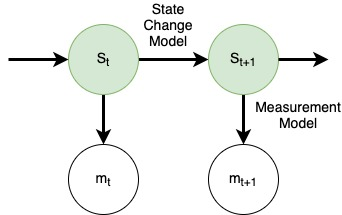

# 3. State Change Model

* We assume a linear model of the state change.

\begin{equation}
        \mathbf{s}_{t+1} = \mathbf{A} \mathbf{s}_{t} + \mathbf{n}
\end{equation}

>> where $\mathbf{n}$ is zero-mean Gaussian noise with covariance $\mathbf{Q}$.

* Note that $\mathbf{s}_{t+1} $ is *a linear combination of two Gaussian random variables, so it is also a Gaussian random variable*. 

* The matrix ${\bf A}$ is pre-specified based on prior domain knowledge. For instance, we need to model a constant velocity model. We can use the following.
    
\begin{equation}
    \begin{bmatrix}
        x \\ y \\ v_x \\ v_y
    \end{bmatrix}_{t+1} = 
    \begin{bmatrix}
    1 & 0 & 1 & 0 \\
    0 & 1 & 0 & 1 \\
    0 & 0 & 1 & 0 \\
    0 & 0 & 0 & 1 
    \end{bmatrix} 
    \begin{bmatrix}
        x \\ y \\ v_x \\ v_y
    \end{bmatrix}_{t} + 
    \begin{bmatrix}
        n_0 \\ n_1 \\ n_2 \\ n_3
    \end{bmatrix}
\end{equation}

* At each time instant, $t$, the following variables are updated: 
    * the mean value of the state $\mathbf{\hat{s}}_t$ and 
    * its covariance $\mathbf{P}$. 
    * These quantities are affected by the state evolution function and also indirectly by the measurement. 

* The update will be in two steps: 
    1. A forward update, followed by 
    2. A measurement-based update.



# 4. Prediction and update of state vector

The below diagram (Petteri Aimonen - Own work, CC0, wikipedia) explains the basic steps of Kalman filtering: prediction and update. It also illustrates how the filter keeps track of not only the mean value of the state, but also the estimated variance.

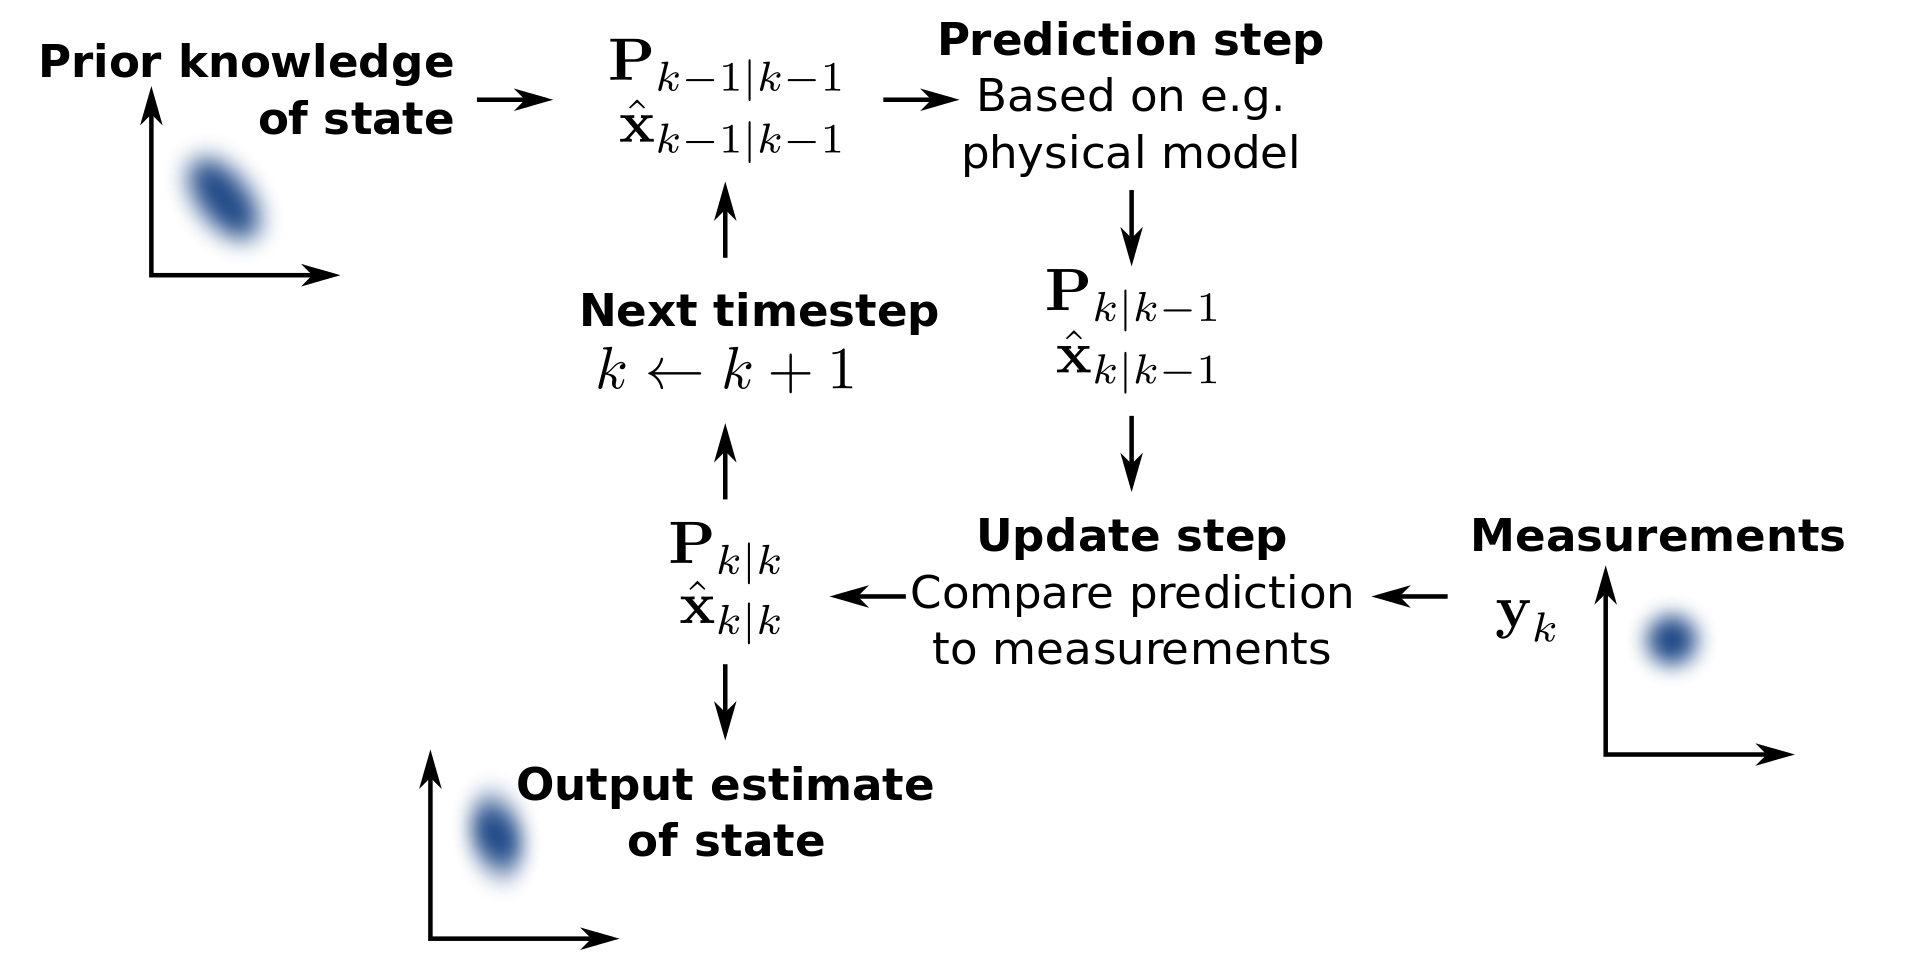

# 4.1 Forward Update

* The state change equation guides the forward update. 

>> We will use the fact that the addition of two independent Gaussian random variables is also a Gaussian. Let $\mathbf{Y} = \mathbf{X}_1 + \mathbf{X}_2 $, where each of them is Gaussian random variable. Then 
$\mathbf{\widehat{Y}} = \mathbf{\widehat{X}_1} + \mathbf{\widehat{X}_2} $ and $\mathbf{\Sigma}_Y = \mathbf{\Sigma}_{X_1} + \mathbf{\Sigma}_{X_2} $.
    
* With this knowledge, we consider the state change model, which is a sum of two independent Gaussian random variables. Recall that the Gaussian random variable representing the states has a mean value, $\hat{\mathbf{s}}_t$, and the covariance $\mathbf{P}_t$. The noise $\mathbf{n}$ is zero-mean Gaussian noise with covariance $\mathbf{Q}$.

* The intermediate estimate of the new state and its covariance, just based on the forward model, is given by

\begin{eqnarray}
        \mathbf{\hat{s}}^{-}_{t+1} & =  & \mathbf{A} \mathbf{\hat{s}}_{t} \\
        \mathbf{P}^{-}_{t+1} & =  & \mathbf{A} \mathbf{P}_{t} \mathbf{A}^T + \mathbf{Q}
\end{eqnarray}
    
* Note that this is **not** the final estimate of the next state as we have to factor in the measurement. Before that, we compute a quantity called the Kalman gain that captures the relative uncertainties in the measurement and the state models.

import matplotlib.patches as patches

    def forward_update (s_hat_t, P_t, A, Q) :
        s_minus_next = A @ s_hat_t
        P_minus_next = (A @ P_t) @ np.transpose(A) + Q
        return (s_minus_next, P_minus_next)



# 4.2 Kalman Gain

The Kalman gain blends the model (intermediate) covariance, $\mathbf{P}^{-}_{t+1}$, and the measurement error covariance, $\mathbf{R}$.

\begin{equation}
        \mathbf{K} = \mathbf{P}^{-}_{t+1} \mathbf{H}^T 
        \left ( \mathbf{H} \mathbf{P}^{-}_{t+1} \mathbf{H}^T  + \mathbf{R}
        \right )^{-1}
\end{equation}

    def compute_kalman_gain (P_minus_next, H, R) :
        return (P_minus_next @ np.transpose(H) @ (np.linalg.inv(H @ (P_minus_next @ np.transpose(H)) + R)))

# 4.3 Measurement Update

\begin{eqnarray}
    \mathbf{\hat{s}}_{t+1} & = & \mathbf{\hat{s}}^{-}_{t+1} + \mathbf{K}  
    \left ( \mathbf{m}_{t+1} - \mathbf{H} \mathbf{\hat{s}}^{-}_{t+1}
    \right )  \\
    \mathbf{P}_{t+1} & = & \left ( \mathbf{I} - \mathbf{K}  \mathbf{H} \right ) \mathbf{P}^{-}_{t+1}
\end{eqnarray}
    
Note how the measurement error, i.e. the terms in parenthesis, is added to the state to update it.

Higher the Kalman gain, the more the state follows the measurement.


    def measurement_update (s_minus_next, P_minus_next, measurement, H,  K) :
            s_hat_next = s_minus_next + K @ (measurement - H @ s_minus_next)
            P_next = (np.eye(K.shape[0]) - K @ H) @ P_minus_next
            return (s_hat_next, P_next)

    

# Exercise: 1D Kalman tracking
Write the 1D versions of (i) state change equation, (ii) measurement equation, (iii) state update equation, (iv) Kalman gain, and (v) measurement gain. 

As illustration, the 1D Kalman gain is given by

\begin{equation}
k = \frac{h (a^2 p_{t+1}^{-} + q)}{h^2(a^2 p_{t+1}^{-} + q) + r}  
\end{equation}


# Exercise: 2D Kalman tracking

Work through the following example with constant velocity model example shown earlier, with the following values of the other variables you would need.

Let the state change model, ${\bf A}$, be

\begin{equation}
{\bf A} =  \begin{bmatrix}
    1 & 0 & 1 & 0 \\
    0 & 1 & 0 & 1 \\
    0 & 0 & 1 & 0 \\
    0 & 0 & 0 & 1 
    \end{bmatrix} 
\end{equation}

We assume half a pixel model error noise, which implies that we have faith in the model. The model error covariance is given by

\begin{equation}
    \mathbf{Q}  = 
    \begin{bmatrix} \frac{1}{4} & & \huge0 & \\
    & \frac{1}{4} &  & \\
    & & \frac{1}{4} & \\
    & \huge0 & & \frac{1}{4} \end{bmatrix}
\end{equation}
    
Initial estimate of the covariance model assumes that it is diagonal, uncorrelated dimensions, with 3 pixel standard deviation in location and 5 pixel standard deviation in velocity.

\begin{equation}
    \mathbf{P}_0  = 
    \begin{bmatrix} 9 & & \huge0 & \\
    & 9 &  & \\
    & & 25 & \\
    & \huge0 & & 25 \end{bmatrix}
\end{equation}
    
The measurement model matrix, ${\bf H}$, is given by

\begin{equation}
{\bf H} = 
\begin{bmatrix}
    1 & 0 & 0 & 0 \\
    0 & 1 & 0 & 0
\end{bmatrix} 
\end{equation}

The measurement error covariance is diagonal too with a standard deviation of 1 pixel.
    \begin{equation}
        \mathbf{R}  = 
        \begin{bmatrix} 1 & 0 \\
        0 & 1  
        \end{bmatrix}
    \end{equation}

Let $\mathbf{\hat{s}}_0 = \begin{bmatrix} 100 \\ 170 \\ 0 \\ 0 \end{bmatrix}$ and measurement be $\mathbf{m}_1 = 
\begin{bmatrix}
        103 \\ 163
\end{bmatrix}$, what is $\mathbf{\hat{s}}_1$?


# Solution (Fill in the blanks)

\begin{eqnarray}
    \mathbf{\hat{s}}^{-}_1  & = & 
    \begin{bmatrix}
    \underline{~~~~~~}  &\underline{~~~~~~}  &\underline{~~~~~~}   & \underline{~~~~~~}   \\
    \underline{~~~~~~}  &\underline{~~~~~~}  &\underline{~~~~~~}   & \underline{~~~~~~}   \\
    \underline{~~~~~~}  &\underline{~~~~~~}  &\underline{~~~~~~}   & \underline{~~~~~~}   \\
    \underline{~~~~~~}  &\underline{~~~~~~}  &\underline{~~~~~~}   & \underline{~~~~~~}   \\
    \end{bmatrix}^{4 x 4} 
    \begin{bmatrix} 100 \\ 170 \\ 0 \\ 0 \end{bmatrix}^{4 x 1} \\ \\
    & = & \begin{bmatrix} 
    \underline{~~~~~~}  \\ \underline{~~~~~~}  \\ \underline{~~~~~~}   \\ \underline{~~~~~~}    
    \end{bmatrix}^{4 x 1}
\end{eqnarray}
    
\begin{eqnarray}
    \mathbf{P}^{-}_1  & = &
    \begin{bmatrix}
    1 & 0 & 1 & 0 \\
    0 & 1 & 0 & 1 \\
    0 & 0 & 1 & 0 \\
    0 & 0 & 0 & 1 
    \end{bmatrix} ^{4 x 4} 
    \begin{bmatrix} 9 & 0 & 0  & 0 \\
       0  & 9 & 0 & 0 \\
       0 & 0 & 25 & 0\\
       0 & 0 & 0 & 25 
    \end{bmatrix}
    \begin{bmatrix}
    \underline{~~~~~~}  &\underline{~~~~~~}  &\underline{~~~~~~}   & \underline{~~~~~~}   \\
    \underline{~~~~~~}  &\underline{~~~~~~}  &\underline{~~~~~~}   & \underline{~~~~~~}   \\
    \underline{~~~~~~}  &\underline{~~~~~~}  &\underline{~~~~~~}   & \underline{~~~~~~}   \\
    \underline{~~~~~~}  &\underline{~~~~~~}  &\underline{~~~~~~}   & \underline{~~~~~~}   \\
    \end{bmatrix}^{4 x 4}   +
        \begin{bmatrix} \frac{1}{4} & 0 & 0 & 0\\
        0 & \frac{1}{4} & 0 & 0 \\
        0 & 0 & \frac{1}{4} & 0 \\
        0 & 0 & 0 & \frac{1}{4} \end{bmatrix} \\
    & = & 
    \begin{bmatrix}
    \underline{~~~~~~}  &\underline{~~~~~~}  &\underline{~~~~~~}   & \underline{~~~~~~}   \\
    \underline{~~~~~~}  &\underline{~~~~~~}  &\underline{~~~~~~}   & \underline{~~~~~~}   \\
    \underline{~~~~~~}  &\underline{~~~~~~}  &\underline{~~~~~~}   & \underline{~~~~~~}   \\
    \underline{~~~~~~}  &\underline{~~~~~~}  &\underline{~~~~~~}   & \underline{~~~~~~}   \\
    \end{bmatrix}^{4 x 4} 
\end{eqnarray}
    
This state prediction gives us a location to relocate the new location and the covariance estimate gives us an area to consider. In our case this is a circle centered at $(100, 170)$ and with radius $\sqrt{34.25} = 5.85$ pixels. We can run the SSD detector and make a new measurement. $\mathbf{m}_1 = \begin{bmatrix}
        103 \\ 163
\end{bmatrix}$

\begin{equation}
        \mathbf{K} = \mathbf{P}^{-}_{t+1} \mathbf{H}^T 
        \left ( \mathbf{H} \mathbf{P}^{-}_{t+1} \mathbf{H}^T  + \mathbf{R}
        \right )^{-1}
\end{equation}


\begin{eqnarray}
    \mathbf{K}  & = &
    \begin{bmatrix}
    0.972 & 0  \\
    0 & 0.972  \\
    0.709 & 0  \\
    0 & 0.709  
    \end{bmatrix} 
\end{eqnarray}
    
The entries capture how much to weight the measurement. Values close to 1 suggest trust the measurement.
    
\begin{eqnarray}
    \mathbf{\hat{s}}_{1} & = & \mathbf{\hat{s}}^{-}_{1} + \mathbf{K}  
    \left ( \mathbf{m}_{1} - \mathbf{H} \mathbf{\hat{s}}^{-}_{1}
    \right )  \\ & & \\
    & = & \begin{bmatrix} \underline{~~~~~~}  \\ \underline{~~~~~~}  \\ \underline{~~~~~~}   \\ \underline{~~~~~~}  \end{bmatrix}^{4 x 1} 
    + \begin{bmatrix}
    0.972 & 0  \\
    0 & 0.972  \\
    0.709 & 0  \\
    0 & 0.709  
    \end{bmatrix}^{4 x 2} \left (
    \begin{bmatrix}
        103 \\ 163
    \end{bmatrix}  - \begin{bmatrix}
    \underline{~~~~~~}  &\underline{~~~~~~}  &\underline{~~~~~~}   & \underline{~~~~~~}   \\
    \underline{~~~~~~}  &\underline{~~~~~~}  &\underline{~~~~~~}   & \underline{~~~~~~}   \\
    \end{bmatrix}^{2 x 4} 
    \begin{bmatrix}  \underline{~~~~~~}  \\ \underline{~~~~~~}  \\ \underline{~~~~~~}   \\ \underline{~~~~~~}   \end{bmatrix}^{4 x 1} 
    \right ) \\ & & \\
    & = & \begin{bmatrix} \underline{~~~~~~}  \\ \underline{~~~~~~}  \\ \underline{~~~~~~}   \\ \underline{~~~~~~}  \end{bmatrix}^{4 x 1} 
\end{eqnarray}

    
\begin{eqnarray}
    \mathbf{P}_{1} & = & \left ( \mathbf{I} - \mathbf{K}  \mathbf{H} \right ) \mathbf{P}^{-}_{1} \\
    & = & 
    \left (
    \begin{bmatrix}
    1 & 0 & 0 & 0 \\
    0 & 1 & 0 & 0 \\
    0 & 0 & 1 & 0 \\
    0 & 0 & 0 & 1 
    \end{bmatrix}  -
    \begin{bmatrix}
    0.972 & 0  \\
    0 & 0.972  \\
    0.709 & 0  \\
    0 & 0.709  
    \end{bmatrix}^{4 x 2} 
    \begin{bmatrix}
    1 & 0 & 0 & 0 \\
    0 & 1 & 0 & 0
    \end{bmatrix} 
    \right )
    \begin{bmatrix}
    \underline{~~~~~~} & 0 & 25 & 0 \\
    0 & \underline{~~~~~~}& 0 & 25 \\
    \underline{~~~~~~} & 0 & \underline{~~~~~~}  & 0 \\
    0 & \underline{~~~~~~}& 0 & \underline{~~~~~~} 
    \end{bmatrix}^{4 x 4} \\
    & = & 
    \begin{bmatrix}
    \underline{~~~~~~} & 0 & 0.71 & 0 \\
    0 & \underline{~~~~~~} & 0 & \underline{~~~~~~} \\
    \underline{~~~~~~}& 0 & \underline{~~~~~~}& 0 \\
    0 & 0.71 & 0 & 7.52 
    \end{bmatrix}^{4 x 4}
\end{eqnarray}
    
Note how the covariance matrix is not diagonal anymore.

# Kalman filter code

In [6]:
import matplotlib.patches as patches

#-------------------------------define update functions ---------------------------------------------
def forward_update (s_hat_t, P_t, A, Q) :
    s_minus_next = A @ s_hat_t
    P_minus_next = (A @ P_t) @ np.transpose(A) + Q
    return (s_minus_next, P_minus_next)

def compute_kalman_gain (P_minus_next, H, R) :
    return (P_minus_next @ np.transpose(H) @ (np.linalg.inv(H @ (P_minus_next @ np.transpose(H)) + R)))

def measurement_update (s_minus_next, P_minus_next, measurement, H,  K) :
    s_hat_next = s_minus_next + K @ (measurement - H @ s_minus_next)
    P_next = (np.eye(K.shape[0]) - K @ H) @ P_minus_next
    return (s_hat_next, P_next)

# Putting it all together -- Kalman filtering

In [7]:
def kalman_filter (current_state_s, current_state_covariance_P,
                   state_change_model_A, model_covariance_Q, 
                   measurement_model_H, measurement_covariance_R, 
                   num_steps, measurement_function) :
    state_history = [[current_state_s, current_state_covariance_P, current_state_s, measurement_covariance_R, 
                      np.zeros([measurement_model_H.shape[1], measurement_model_H.shape[0]])]]
    for i in range (num_steps) :
        # ----- Run forward model ---------------
        intermediate_state_s, intermediate_state_covariance_P = forward_update (current_state_s, current_state_covariance_P, 
                                                                                state_change_model_A, model_covariance_Q)
        #-------Perform Measurement ---------
        measurement_m, measurement_covariance_R = measurement_function (current_state_s[0:2,:], intermediate_state_s[0:2,:], intermediate_state_covariance_P, measurement_covariance_R)  
        #------- Compute Kalman Gain ------------
        kalman_gain = compute_kalman_gain (intermediate_state_covariance_P, measurement_model_H, measurement_covariance_R)
        
        #-------Measurement Update---------
        next_state_s, next_state_covariance_P = measurement_update (intermediate_state_s, intermediate_state_covariance_P, 
                                                                    measurement_m, measurement_model_H,  kalman_gain)
        state_history.append([next_state_s, next_state_covariance_P, measurement_m, measurement_covariance_R, kalman_gain])
        
        current_state_s = next_state_s
        current_state_covariance_P = next_state_covariance_P
        #print('Measurement:\n {}\n Next State:\n{} \nKalman gain:\n{}'.format(measurement_m, next_state_s, kalman_gain))
    return(state_history)

# Example: Bouncing ball

We consider a dot moving in a sine wave pattern. The motion consists of acceleration and deceleration along the vertical direction and constant velocity along the horizontal direction.

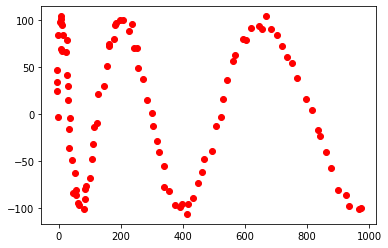

In [8]:
def ball_in_sine (point_locations, predicted_locations, predicted_cov, measure_cov) :
    global time
    noise_sigma = 5
    x = 100*np.sin(time*np.pi/90) + np.random.normal(0, noise_sigma)
    y = .004*time*time + np.random.normal(0, noise_sigma)
    time = time + 5
    return(np.array([[x], [y]]), np.array([[noise_sigma**2, 0], [0, noise_sigma**2]]))

time = 0
for i in range (100):
    point, cov = ball_in_sine ([], [], [], [])
    plt.plot(point[1,0], point[0,0], 'ro')

## 1. Just position as state model

In [ ]:
#------------position model------------------
state = np.array([[0],[0]]) # (x, y) [just position as state]
P = np.eye(2)   # state covariance (error)

A = np.array([[1, 0], 
              [0, 1]]) # state model -- stationary point
Q = np.eye(2)   # model covariance (error)

H = np.array([[1, 0], 
              [0, 1]])  # measurement model -- can directly measure the location
R = np.array([[1, 0],    [0, 1]])  # measurement covariance (error)

## 2. Position + velocity as state model

In [10]:
#------------position + velocity model------------------
state = np.array([[0],[0],[0],[0]]) # (x, y, vx, vy) [position  and velocity as state]
P = np.eye(4) # state covariance (error)

A = np.array([[1, 0, 1, 0], 
              [0, 1, 0, 1], 
              [0, 0, 1, 0], 
              [0, 0, 0, 1]]) # state model -- constant velocity model
Q = np.eye(4)  # model covariance (error)

H = np.array([[1, 0, 0, 0], 
              [0, 1, 0, 0]])  # measurement model -- can directly measure only the location
R = np.array([[1, 0],    [0, 1]])# measurement covariance (error)

## 3. Position + velocity + acceleration model

In [9]:
#------------position + velocity + acceleration model------------------
state = np.array([[0],[0],[0],[0],[0],[0]]) # (x, y, vx, vy, ax, ay) [position, velocity, acceleration as state]
P = np.eye(6)
A = np.array([[1, 0, 1, 0, 0, 0], 
              [0, 1, 0, 1, 0, 0], 
              [0, 0, 1, 0, 1, 0], 
              [0, 0, 0, 1, 1, 0],
              [0, 0, 0, 0, 1, 0],
              [0, 0, 0, 0, 0, 1]]) # state model -- constant acceleration model
Q = 0.1* np.eye(6) # model covariance (error)

H = np.array([[1, 0, 0, 0, 0, 0], 
              [0, 1, 0, 0, 0, 0]]) # measurement model -- can directly measure only the location
R = np.array([[1, 0],    [0, 1]]) # measurement covariance (error)

**Run one of the three cells above to select the model and then run the cell below to execute the Kalman filter**

## Items to vary
1. Q -- covariance of modeling error -- 1 to 50. Notice the Kalman gain as Q increases. Lower Q means high confidence in the model and the tracker follows the model and smooths the measurement.
2. Vary the added randomness in "ball-in-sine"
3. Vary the state vector to include differnt mixes of position, velocity, and acceleration.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future ver

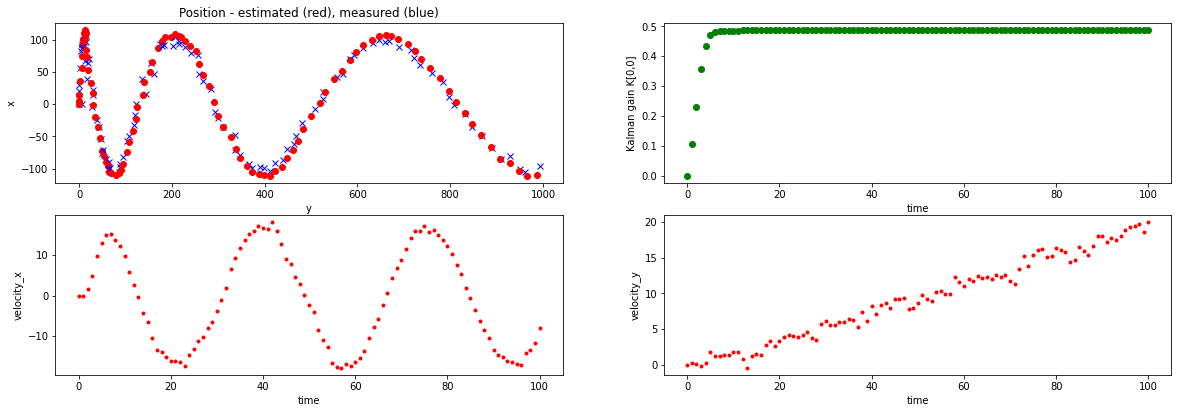

In [11]:
#-------------------------------------------------------------
time = 1
np.set_printoptions( precision=2, suppress=True)
history = kalman_filter (state, P, A, Q, H, R, 100, ball_in_sine)
plt.figure(figsize=(20,10))
for i in range(len(history)) :
    state,P, measurement, R, kalman = history[i] 
    plt.subplot(3,2,1)
    plt.plot(measurement[1,0], measurement[0,0], 'bx')
    plt.plot(state[1,0], state[0,0], 'ro')
    plt.title('Position - estimated (red), measured (blue)')
    plt.xlabel('y')
    plt.ylabel('x')
    plt.subplot(3,2,2)
    plt.plot(i, kalman[0,0], 'go')
    plt.xlabel('time')
    plt.ylabel('Kalman gain K[0,0]')
    if (state.shape[0] > 2) :
        plt.subplot(3,2,3)
        plt.plot(i, state[2,0], 'r.')
        plt.ylabel('velocity_x')
        plt.xlabel('time')
        plt.subplot(3,2,4)
        plt.plot(i, state[3,0], 'r.')
        plt.ylabel('velocity_y')
        plt.xlabel('time')
        if (state.shape[0] > 4) :
            plt.subplot(3,2,5)
            plt.plot(i, state[4,0], 'r.')
            plt.ylabel('acceleration_x')
            plt.xlabel('time')
            plt.subplot(3,2,6)
            plt.plot(i, state[5,0], 'r.')
            plt.ylabel('acceleration_y')
            plt.xlabel('time')
